# Model evaluations

In [1]:
import pandas as pd
import numpy as np
import json
import os
import re
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import shutil

In [2]:
MODEL_OUTPUT = "experiments/"

In [3]:
def parse_model_name(model):
    params = dict()
    params["model"] = re.findall(r"model_(.*)_max", model)[0]
    params["max_sequence_length"] = re.findall(r"max_sequence_length_([0-9]*)_epochs", model)[0]
    params["epochs"] = re.findall(r"epochs_([0-9]*)", model)[0]
    params["suffix"] = re.findall(r"epochs_[0-9](.*)", model)[0]
    try:
        params["language"] = re.findall(r"run_([a-z\-]*)_", model)[0]
        params["run"] = int(re.findall(r"run_[a-z\-]*_([0-9]*)", model)[0])
    except:
        params["language"] = re.findall(r"_([a-z\-]*)", model)[-1]
        params["run"] = None
    return params

def parse_global_data(global_dict, model_name):
    final_dict = parse_model_name(model_name)
    final_dict.update(global_dict)
    return pd.DataFrame(final_dict, index=[0])

def parse_class_report(report):
    all_rows = [entry.strip() for entry in report.split("\n")]
    rows = [entry for entry in all_rows if entry]

    header = ["label"]
    header +=  re.findall(r"([^\s]+)", rows[0].replace("-score", ""))
    rows = rows[1:]

    data = []
    for row in rows:
        row = row.replace(" avg", "_avg")
        row = row.replace("accuracy", "accuracy _ _")
        data.append(re.findall(r"([^\s]+)", row))
    return pd.DataFrame(data=data, columns=header)



def parse_all_class_reports(report_list):
    all_reports = []
    for report in report_list:
        all_reports.append(parse_class_report(report))
    return all_reports

# Check which models have been run

In [4]:
#check which results have (not) been stored per model
no_results = []
no_pred = []
no_res_pred = []

for model in os.listdir(MODEL_OUTPUT):
    model_path = os.path.join(MODEL_OUTPUT, model)
    if os.path.isdir(model_path):
        results = [x for x in os.listdir(model_path) if "results" in x]
        predictions = [x for x in os.listdir(model_path) if "_pred" in x]
        if len(results) == 0:
            if len(predictions) == 0:
                no_res_pred.append(model)
            else:
                no_results.append(model)
        else:
            if len(predictions) == 0:
                no_pred.append(model)

In [5]:
no_res_pred

['model_dbmdz_bert_base_historic_multilingual_cased_max_sequence_length_256_epochs_3_run_multilingual_2',
 'model_dbmdz_bert_base_historic_multilingual_cased_max_sequence_length_256_epochs_3_run_multilingual_3',
 'model_bert_base_cased_max_sequence_length_256_epochs_3_run_multilingual_4',
 'model_dbmdz_bert_base_historic_multilingual_cased_max_sequence_length_256_epochs_3_run_multilingual_1']

In [6]:
#delete folders which only contain the logfile (model was instantiated but not run)
for model in os.listdir(MODEL_OUTPUT):
    model_path = os.path.join(MODEL_OUTPUT, model)
    if os.path.isdir(model_path):
        if len([x for x in os.listdir(model_path)]) == 2: #logfile and label map
            print("Deleting model folder:", model)
            #os.remove(os.path.join(model_path, "logging.log"))
            #os.remove(os.path.join(model_path, "label_map.json"))
            #os.rmdir(model_path)

Deleting model folder: model_xlm_roberta_base_max_sequence_length_256_epochs_3_run_fr_2


## Token-Level Classification

In [6]:
ne_global_metrics = pd.DataFrame()
ne_test_metrics = dict()
sent_test_metrics = dict()

for model in os.listdir(MODEL_OUTPUT):
    try:
        json_files = [ x for x in os.listdir(os.path.join(MODEL_OUTPUT, model)) if "all_results" in x ]
    #ignore files in experiments folder
    except:
        continue
    
    #if model folder exists, but no json (results) file in the folder
    if not json_files:
        print("Was not able to get results for model:", model)
        continue
    

    #for all json (results) files, parse results and save them in the dataframe/dictionaries
    for file in json_files:
        filepath = os.path.join(MODEL_OUTPUT, model, file)

        modelname = model
        #if trained multilingual, but evaluated separately for fr and de, need to store information which dev/test set
        if "run_multilingual" in modelname:
            lang = re.findall(r"all_results_([a-z]+).json", file)[0]
            modelname = modelname.replace("run_multilingual", f"run_multilingual-{lang}")

        with open(filepath, "r") as f:
            model_res = json.load(f)

            #parse data and save it in different formats    
            try:
                dev_global = parse_global_data(model_res["dev"]["global"][-1], modelname)
            except:
                dev_global = parse_global_data(model_res["dev"]["global"], modelname)
            dev_global.insert(4, "set", "dev") #insert column at 5th position

            test_global = parse_global_data(model_res["test"]["global"], modelname)
            test_global["set"] = "test"
            
            ne_global_metrics = pd.concat([ne_global_metrics, dev_global, test_global], ignore_index=True)
            ne_test_metrics[modelname] = parse_class_report(model_res["test"]["token-level"])
            sent_test_metrics[modelname] = parse_class_report(model_res["test"]["sent-level"])
        
        

ne_global_metrics["max_sequence_length"] = ne_global_metrics["max_sequence_length"].astype(int)
ne_global_metrics["epochs"] = ne_global_metrics["epochs"].astype(int)

Was not able to get results for model: model_xlm_roberta_base_max_sequence_length_256_epochs_3_run_de_4
Was not able to get results for model: model_dbmdz_bert_base_historic_multilingual_cased_max_sequence_length_64_epochs_3_run_fr_4
Was not able to get results for model: model_xlm_roberta_base_max_sequence_length_128_epochs_3_run_de_2
Was not able to get results for model: model_dbmdz_bert_base_historic_multilingual_cased_max_sequence_length_256_epochs_3_run_multilingual_2
Was not able to get results for model: model_dbmdz_bert_base_historic_multilingual_cased_max_sequence_length_128_epochs_3_run_fr_2
Was not able to get results for model: model_dbmdz_bert_base_historic_multilingual_cased_max_sequence_length_256_epochs_3_run_fr_5
Was not able to get results for model: model_dbmdz_bert_base_historic_multilingual_cased_max_sequence_length_64_epochs_3_run_fr_1
Was not able to get results for model: model_camembert_base_max_sequence_length_128_epochs_3_run_fr_4
Was not able to get results

In [7]:
#raw output
#model_res

In [8]:
ne_test = ne_global_metrics.loc[(ne_global_metrics["set"]=="test") &
                                    ne_global_metrics["run"].notna()]
grouped_ne_test = ne_test.groupby(["model", "language", "max_sequence_length"]).agg({"run": "count", "f1": [np.mean, np.std]})
grouped_ne_test

run        f1          
                                                     count      mean       std
model            language        max_sequence_length                          
bert_base_cased  de              64                      5  0.848716  0.013136
                                 128                     5  0.842078  0.028468
                                 256                     5  0.759259  0.000000
                                 512                     5  0.782609  0.000000
                 fr              64                      5  0.752789  0.027616
...                                                    ...       ...       ...
xlm_roberta_base multilingual-de 128                     5  0.800000  0.000000
                                 256                     5  0.776699  0.000000
                 multilingual-fr 64                      5  0.676580  0.000000
                                 128                     5  0.678700  0.000000
                                 256                     5  0.664311  0.000000

[61 rows x 3 columns]

In [9]:
ne_dev = ne_global_metrics.loc[(ne_global_metrics["set"]=="dev") &
                                    ne_global_metrics["run"].notna()]
ne_dev.groupby(["model", "language", "max_sequence_length"]).agg({"run": "count", "f1": [np.mean, np.std]})

run        f1          
                                                     count      mean       std
model            language        max_sequence_length                          
bert_base_cased  de              64                      5  0.639099  0.036157
                                 128                     5  0.651315  0.039331
                                 256                     5  0.666667  0.000000
                                 512                     5  0.576923  0.000000
                 fr              64                      5  0.757574  0.014531
...                                                    ...       ...       ...
xlm_roberta_base multilingual-de 128                     5  0.636364  0.000000
                                 256                     5  0.530612  0.000000
                 multilingual-fr 64                      5  0.650000  0.000000
                                 128                     5  0.676056  0.000000
                                 256                     5  0.669767  0.000000

[61 rows x 3 columns]

In [10]:
ne_global_metrics

,model,max_sequence_length,epochs,suffix,set,language,run,loss,precision,recall,f1
0,bert_base_german_cased,128,3,_run_de_2,dev,de,2,0.061811,0.565217,0.565217,0.565217
1,bert_base_german_cased,128,3,_run_de_2,test,de,2,0.080707,0.895833,0.811321,0.851485
2,bert_base_cased,64,3,_run_fr_1,dev,fr,1,0.065868,0.684615,0.831776,0.751055
3,bert_base_cased,64,3,_run_fr_1,test,fr,1,0.084497,0.755245,0.739726,0.747405
4,xlm_roberta_base,512,3,_run_fr_2,dev,fr,2,0.130950,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
621,xlm_roberta_base,64,3,_run_fr_4,test,fr,4,0.092315,0.714286,0.604027,0.654545
622,bert_base_multilingual_cased,64,3,_run_multilingual-de_3,dev,multilingual-de,3,0.069773,0.600000,0.652174,0.625000
623,bert_base_multilingual_cased,64,3,_run_multilingual-de_3,test,multilingual-de,3,0.103637,0.728814,0.843137,0.781818
624,bert_base_multilingual_cased,64,3,_run_multilingual-fr_3,dev,multilingual-fr,3,0.063259,0.738095,0.853211,0.791489


In [11]:
def get_language(modelname):
    if "multilingual-de" in modelname:
        return "multi_de"
    elif "multilingual-fr" in modelname:
        return "multi_fr"
    elif "de" in modelname:
        return "de"
    elif "fr" in modelname:
        return "fr"
    else:
        raise AssertionError ("no language recognized")

In [25]:
models = ['{}_{}_{}'.format(h, i, j) for h, i, j in grouped_ne_test.index]
y = grouped_ne_test["f1"]["mean"]
y_err = grouped_ne_test["f1"]["std"]
color_dict = {"de": "r",
              "fr": "g",
              "multi_de": "brown",
              "multi_fr": "darkslategrey"}
size_dict = {"_64": 64,
               "128": 128,
               "256": 256,
               "512": 512}
size = [size_dict[model[-3:]] for model in models]
colors = [color_dict[get_language(model)] for model in models ]

#save model name each time it changes (x), alternating true-false list per model (bo)
x, bo = [], []
modelname = None
flag = False
for model in grouped_ne_test.index.get_level_values(0):
    if modelname != model:
        flag = not flag
        modelname = model
        x.append(model)
    else:
        x.append("")
    bo.append(flag)

#include a space between two models
n_x, n_y, n_y_err, n_models, n_size, n_colors, n_bo = [], [], [], [], [], [], []
for ix, iy, iy_err, imodels, isize, icolors, ibo in zip(x, y, y_err, models, size, colors, bo):
    if ix != "":
        n_x.append("")
        n_y.append(0)
        n_y_err.append(0)
        n_models.append(ix + "_gap")
        n_size.append(64)
        n_colors.append("white")
        n_bo.append(True)

    n_x.append(ix)
    n_y.append(iy)
    n_y_err.append(iy_err)
    n_models.append(imodels)
    n_size.append(isize)
    n_colors.append(icolors)
    n_bo.append(ibo)

"""
#shift label names to the right
shift = 3
n_x = [""] * shift + n_x[:-shift]

"""
n_x = [x.replace("_", "\n") for x in n_x]
x_pos_dict = {x: i for i, x in enumerate(n_x) if x != ""}
pos_l = list(x_pos_dict.values())
pos_l.append(len(n_x))
x_pos = [pos_l[i] + int((pos_l[i+1] - pos_l[i])/2) for i in range(len(pos_l)-1)]
n_x = [""] * len(n_x)
for i, model in enumerate(x_pos_dict.keys()):
    n_x[x_pos[i]] = model

/tmp/ipykernel_3022226/4063369624.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


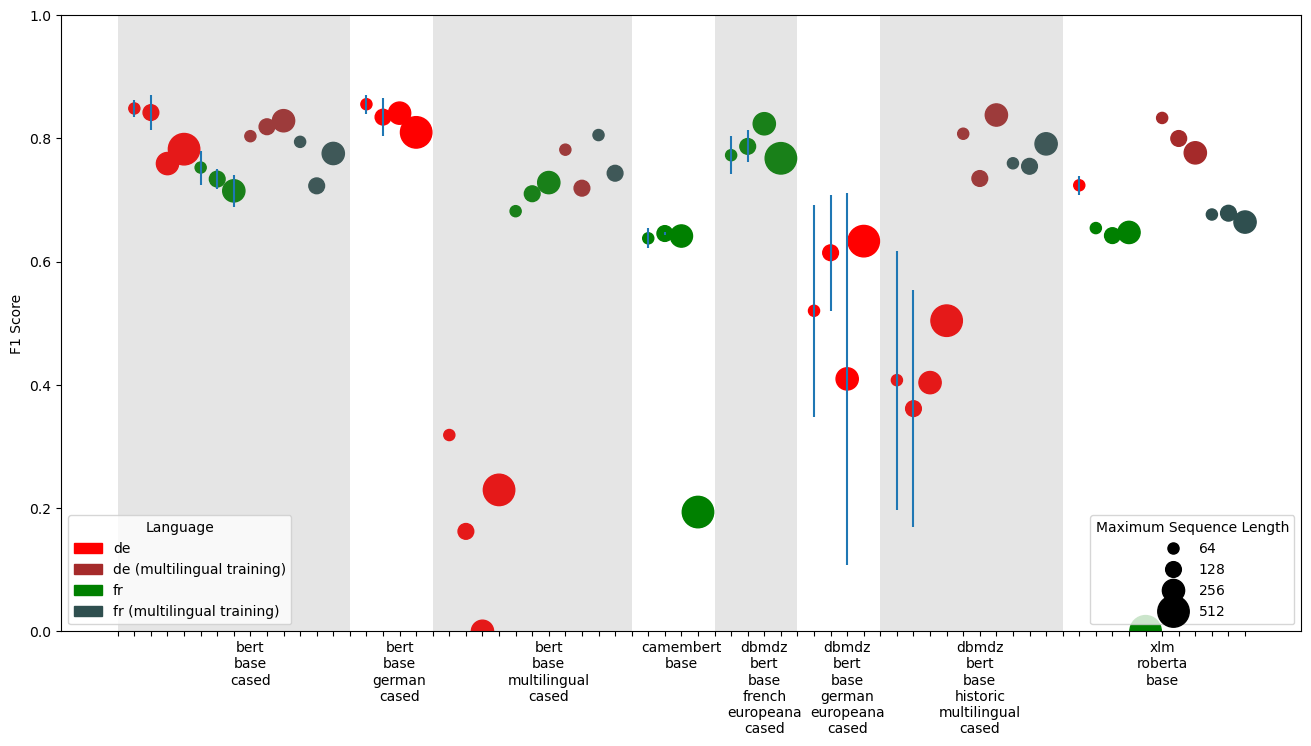

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
ax.errorbar(n_models, n_y, yerr=n_y_err, ls='none')
sc = plt.scatter(n_models, n_y, c=n_colors, s=n_size)

#change background based on models
ax.fill_between(n_models, 1, 0, where=n_bo, facecolor='grey', alpha=.2, step="mid")
ax.set_ylim(0, 1)

ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75
ax.set_ylabel("F1 Score")

#legend
# produce a legend with the unique colors from the scatter
#legend1 = ax.legend(*sc.legend_elements(prop="colors"),
#                    loc="lower left", title="Language",)
red_patch = mpatches.Patch(color='red', label='de')
green_patch = mpatches.Patch(color='green', label='fr')
dark_red_patch = mpatches.Patch(color='brown', label='de (multilingual training)')
dark_green_patch = mpatches.Patch(color='darkslategrey', label='fr (multilingual training)')

legend1 = ax.legend(handles=[red_patch, dark_red_patch, green_patch, dark_green_patch], title="Language", loc="lower left")
ax.add_artist(legend1)
legend2 = ax.legend(*sc.legend_elements(prop="sizes"),
                    loc="lower right", title="Maximum Sequence Length",)
plt.show()

### check missing variance in std

In [ ]:
ne_global_metrics[ne_global_metrics["model"]=="bert_base_cased"]

In [33]:
ne_test_metrics["model_bert_base_cased_max_sequence_length_64_epochs_3_run_multilingual-de_1"]

,label,precision,recall,f1,support
0,org.ent.pressagency.AFP,1.0000,1.0000,1.0000,5
1,org.ent.pressagency.AP,0.8000,0.6667,0.7273,6
2,org.ent.pressagency.ATS-SDA,0.0000,0.0000,0.0000,0
3,org.ent.pressagency.DNB,1.0000,1.0000,1.0000,3
4,org.ent.pressagency.Europapress,1.0000,1.0000,1.0000,1
5,org.ent.pressagency.Extel,1.0000,1.0000,1.0000,1
6,org.ent.pressagency.Havas,0.7778,1.0000,0.8750,7
7,org.ent.pressagency.Reuters,0.8000,1.0000,0.8889,4
8,org.ent.pressagency.UP-UPI,0.7500,0.7500,0.7500,4
9,org.ent.pressagency.Wolff,1.0000,1.0000,1.0000,6


In [34]:
ne_test_metrics["model_bert_base_cased_max_sequence_length_64_epochs_3_run_multilingual-de_2"]

,label,precision,recall,f1,support
0,org.ent.pressagency.AFP,1.0000,1.0000,1.0000,5
1,org.ent.pressagency.AP,0.8000,0.6667,0.7273,6
2,org.ent.pressagency.ATS-SDA,0.0000,0.0000,0.0000,0
3,org.ent.pressagency.DNB,1.0000,1.0000,1.0000,3
4,org.ent.pressagency.Europapress,1.0000,1.0000,1.0000,1
5,org.ent.pressagency.Extel,1.0000,1.0000,1.0000,1
6,org.ent.pressagency.Havas,0.7778,1.0000,0.8750,7
7,org.ent.pressagency.Reuters,0.8000,1.0000,0.8889,4
8,org.ent.pressagency.UP-UPI,0.7500,0.7500,0.7500,4
9,org.ent.pressagency.Wolff,1.0000,1.0000,1.0000,6


In [44]:
import datetime

model_time = dict()
for model in os.listdir(MODEL_OUTPUT):
    model_path = os.path.join(MODEL_OUTPUT, model)
    if os.path.isdir(model_path):
        timestamp = os.path.getmtime(model_path)
        model_time[model] = datetime.datetime.fromtimestamp(timestamp)

In [59]:
#no variation anymore from middle of 30th of May
model_time = dict(sorted(model_time.items(), key=lambda item: item[1]))
list(model_time.items())[85:100]

[('model_bert_base_cased_max_sequence_length_256_epochs_3_run_fr_5',
  datetime.datetime(2023, 5, 30, 11, 39, 49, 462765)),
 ('model_camembert_base_max_sequence_length_64_epochs_3_run_fr_1',
  datetime.datetime(2023, 5, 30, 11, 59, 53, 717510)),
 ('model_camembert_base_max_sequence_length_64_epochs_3_run_fr_2',
  datetime.datetime(2023, 5, 30, 12, 15, 39, 842220)),
 ('model_camembert_base_max_sequence_length_64_epochs_3_run_fr_3',
  datetime.datetime(2023, 5, 30, 12, 31, 24, 514941)),
 ('model_camembert_base_max_sequence_length_64_epochs_3_run_fr_4',
  datetime.datetime(2023, 5, 30, 12, 47, 4, 479697)),
 ('model_camembert_base_max_sequence_length_64_epochs_3_run_fr_5',
  datetime.datetime(2023, 5, 30, 13, 2, 51, 880395)),
 ('model_camembert_base_max_sequence_length_128_epochs_3_run_fr_1',
  datetime.datetime(2023, 5, 30, 13, 29, 31, 176362)),
 ('model_xlm_roberta_base_max_sequence_length_64_epochs_3_run_de_1',
  datetime.datetime(2023, 5, 30, 13, 51, 46, 2103)),
 ('model_xlm_roberta_ba

## Sentence-Level Classification

In [60]:
sent_global_metrics = pd.DataFrame()

for model in sent_test_metrics:
    test_metrics = sent_test_metrics[model]
    chosen_metrics = test_metrics[test_metrics["label"].isin(["0", "1", "macro_avg"])] 

    #add model specifications at beginning of dataframe
    for i, items in enumerate(parse_model_name(model).items()):
        col, value = items
        chosen_metrics.insert(i, col, value)
    
    sent_global_metrics = pd.concat([sent_global_metrics, chosen_metrics])

sent_global_metrics[["precision", "recall", "f1"]] = sent_global_metrics[["precision", "recall", "f1"]].astype(float)

In [61]:
sent_global_metrics[sent_global_metrics["label"]=="macro_avg"].sort_values(by="f1", ascending=False)

,model,max_sequence_length,epochs,suffix,language,run,label,precision,recall,f1,support
3,bert_base_german_cased,128,3,_run_de_3,de,3,macro_avg,0.9593,0.9681,0.9636,1077
3,dbmdz_bert_base_french_europeana_cased,64,3,_fr,fr,None,macro_avg,0.9693,0.9485,0.9586,2881
3,dbmdz_bert_base_french_europeana_cased,512,3,_run_fr_1,fr,1,macro_avg,0.9685,0.9419,0.9548,2881
3,dbmdz_bert_base_french_europeana_cased,512,3,_run_fr_5,fr,5,macro_avg,0.9685,0.9419,0.9548,2881
3,dbmdz_bert_base_french_europeana_cased,512,3,_run_fr_3,fr,3,macro_avg,0.9685,0.9419,0.9548,2881
...,...,...,...,...,...,...,...,...,...,...,...
3,xlm_roberta_base,512,3,_run_fr_5,fr,5,macro_avg,0.4740,0.5000,0.4866,2881
3,xlm_roberta_base,512,3,_run_fr_3,fr,3,macro_avg,0.4740,0.5000,0.4866,2881
3,xlm_roberta_base,512,3,_run_fr_2,fr,2,macro_avg,0.4740,0.5000,0.4866,2881
3,xlm_roberta_base,512,3,_run_fr_4,fr,4,macro_avg,0.4740,0.5000,0.4866,2881


In [62]:
sent_test = sent_global_metrics[(sent_global_metrics["label"]=="macro_avg") &
                                sent_global_metrics["run"].notna()]
sent_test.groupby(["model", "language", "max_sequence_length"]).agg({"run": "count", "f1": [np.mean, np.std]})

run       f1          
                                                     count     mean       std
model            language        max_sequence_length                         
bert_base_cased  de              128                     5  0.91900  0.003991
                                 256                     5  0.91640  0.000000
                                 512                     5  0.93050  0.000000
                                 64                      5  0.91484  0.006019
                 fr              128                     5  0.92954  0.005518
...                                                    ...      ...       ...
xlm_roberta_base multilingual-de 256                     5  0.90820  0.000000
                                 64                      5  0.92980  0.000000
                 multilingual-fr 128                     5  0.90580  0.000000
                                 256                     5  0.90190  0.000000
                                 64                      5  0.91410  0.000000

[61 rows x 3 columns]

# HIPE Scorer

In [97]:
ne_HIPE = pd.DataFrame()

for model in os.listdir(MODEL_OUTPUT):
    model_path = os.path.join(MODEL_OUTPUT, model)
    #exclude files and early experiments
    if not os.path.isdir(model_path):
        continue
    if not "run" in model:
        continue
    
    json_files = [ x for x in os.listdir(os.path.join(MODEL_OUTPUT, model)) if "pred_nerc_fine.json" in x ]
    #continue if no nerc_fine predictions in experiments folder
    if not json_files:
        continue
    try:
        json_test_file = [x for x in json_files if "test" in x][0]
    except:
        print("No test file, but:", json_files)
        continue
        
    with open(os.path.join(model_path, json_test_file), "r") as f:
        model_res = json.load(f)

    cur_df = pd.DataFrame(parse_model_name(model), index=[0])
    cur_df["f1"] = model_res["NE-FINE-LIT"]["TIME-ALL"]["LED-ALL"]["ALL"]["ent_type"]["F1_macro"]

    ne_HIPE = pd.concat([ne_HIPE, cur_df], ignore_index=True)

ne_HIPE["max_sequence_length"] = ne_HIPE["max_sequence_length"].astype(int)
ne_HIPE["epochs"] = ne_HIPE["epochs"].astype(int)
ne_HIPE = ne_HIPE.sort_values(by=["model", "max_sequence_length", "suffix"])

In [99]:
ne_HIPE.groupby(["model", "language", "max_sequence_length"]).agg({"run": "count", "f1": [np.mean, np.std]})

run  \
                                                                         count   
model                                       language max_sequence_length         
bert_base_cased                             de       64                      5   
                                                     128                     5   
                                                     256                     5   
                                                     512                     5   
                                            fr       64                      5   
                                                     128                     5   
                                                     256                     5   
bert_base_german_cased                      de       64                      5   
                                                     128                     5   
                                                     256                     5   
                                                     512                     5   
bert_base_multilingual_cased                de       64                      5   
                                                     128                     5   
                                                     256                     5   
                                                     512                     5   
                                            fr       64                      5   
                                                     128                     5   
                                                     256                     5   
camembert_base                              fr       64                      5   
                                                     128                     5   
                                                     256                     5   
                                                     512                     5   
dbmdz_bert_base_french_europeana_cased      fr       64                      5   
                                                     128                     5   
                                                     256                     5   
                                                     512                     5   
dbmdz_bert_base_german_europeana_cased      de       64                      5   
                                                     128                     5   
                                                     256                     5   
                                                     512                     5   
dbmdz_bert_base_historic_multilingual_cased de       64                      5   
                                                     128                     5   
                                                     256                     5   
                                                     512                     5   
                                            fr       64                      5   
                                                     128                     5   
                                                     256                     5   
xlm_roberta_base                            de       64                      5   
                                                     128                     5   
                                                     256                     5   
                                            fr       64                      2   

                                                                                f1  \
                                                                              mean   
model                                       language max_sequence_length             
bert_base_cased                             de       64                   0.771494   
                                                     128                  0.782498   
                                    

## Save evaluation data

In [29]:
ne_global_metrics.to_pickle(os.path.join(MODEL_OUTPUT, "NE_metrics.pkl"))
sent_global_metrics.to_pickle(os.path.join(MODEL_OUTPUT, "Sent_metrics.pkl"))

In [30]:
with open(os.path.join(MODEL_OUTPUT, 'NE_all_test_metrics.pkl'), 'wb') as f:
    pickle.dump(ne_test_metrics, f)

with open(os.path.join(MODEL_OUTPUT, 'Sent_all_test_metrics.pkl'), 'wb') as f:
    pickle.dump(sent_test_metrics, f)

In [65]:
RESULTS_DIR = "results"

models = [doc for doc in os.listdir(MODEL_OUTPUT) 
          if os.path.isdir(os.path.join(MODEL_OUTPUT,doc))]

for model in models: 
    results_to_save = [doc for doc in os.listdir(os.path.join(MODEL_OUTPUT, model)) if ("all_results" in doc) or (".tsv" in doc)]
    if results_to_save:
        os.makedirs(os.path.join(RESULTS_DIR, model), exist_ok=True)
        for result in results_to_save:
            shutil.copyfile(os.path.join(MODEL_OUTPUT, model, result), os.path.join(RESULTS_DIR, model, result))
        print(f"Saved {results_to_save} in folder {os.path.join(RESULTS_DIR, model)}")

#make a zipfile out of results directory
print(f"Make zipfile of {RESULTS_DIR}")
shutil.make_archive("results", 'zip', "results")
print(f"Done")

Saved ['newsagency-data-2-dev-de_pred.tsv', 'newsagency-data-2-test-de_pred.tsv', 'all_results.json'] in folder results/model_bert_base_german_cased_max_sequence_length_128_epochs_3_run_de_2
Saved ['newsagency-data-2-dev-de_pred.tsv', 'newsagency-data-2-test-de_pred.tsv'] in folder results/model_xlm_roberta_base_max_sequence_length_256_epochs_3_run_de_4
Saved ['newsagency-data-2-test-fr_pred.tsv', 'newsagency-data-2-dev-fr_pred.tsv', 'all_results.json'] in folder results/model_bert_base_cased_max_sequence_length_64_epochs_3_run_fr_1
Saved ['newsagency-data-2-dev-de_pred.tsv', 'newsagency-data-2-test-de_pred.tsv', 'all_results.json'] in folder results/model_bert_base_cased_max_sequence_length_128_epochs_3_run_de_5
Saved ['newsagency-data-2-test-fr_pred.tsv', 'newsagency-data-2-dev-fr_pred.tsv', 'all_results.json'] in folder results/model_camembert_base_max_sequence_length_64_epochs_3_run_fr_3
Saved ['newsagency-data-2-test-fr_pred.tsv', 'newsagency-data-2-dev-fr_pred.tsv', 'all_results_